
--- Realizando predicción y evaluación con un modelo LSTM de TensorFlow ---


c:\Users\mferrera\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Predicciones del Margen para los últimos 12 meses:
   Margen_Predicho Fecha_Anio_Mes
0         0.021221        2025-03
1         0.015400        2025-04
2         0.021601        2025-05
3         0.015453        2025-06
4         0.015107        2025-07
5         0.015426        2025-08


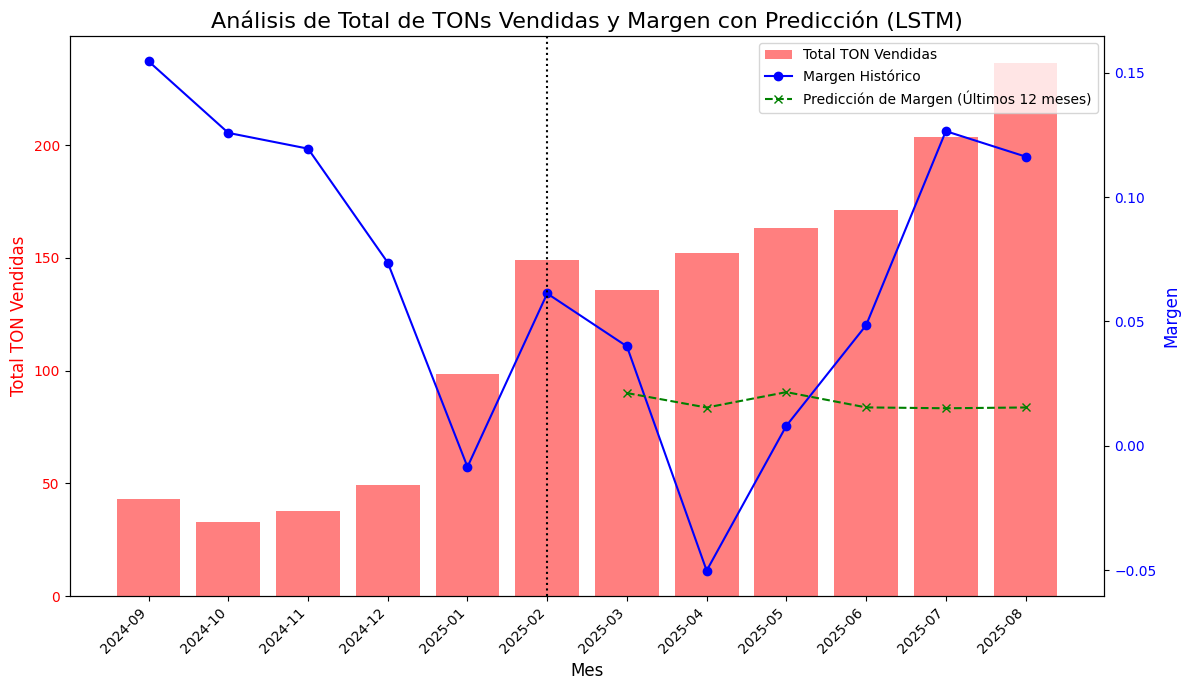

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Parte 1: Cargar y preparar los datos históricos (sin cambios) ---
df = pd.read_excel(
    "C:/Users/mferrera/Documents/Ventaspipsagt.xlsx",
    sheet_name="Hoja1",
    skiprows=2
)

df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Fecha_Anio_Mes'] = df['Fecha'].dt.strftime('%Y-%m')

promedio_mensual = df.groupby('Fecha_Anio_Mes').agg(
    total_ventas=('TotalVenta', 'sum'),
    total_costos=('CostoTotal', 'sum'),
    total_ton=('Total TON vendidas', 'sum')
).reset_index()

promedio_mensual['Margen'] = (promedio_mensual['total_ventas'] - promedio_mensual['total_costos']) / promedio_mensual['total_ventas']

# --- Parte 2: Predicción del Margen de los últimos 12 meses con TensorFlow (LSTM) ---
print("\n--- Realizando predicción y evaluación con un modelo LSTM de TensorFlow ---")

# 1. Preparar los datos
data_margen = promedio_mensual['Margen'].values.reshape(-1, 1)

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_margen)

# 2. Dividir los datos para entrenamiento y prueba
# Ajustar test_size si los datos son insuficientes
if len(data_scaled) <= look_back:
    raise ValueError("No hay suficientes datos para entrenar y probar el modelo LSTM. Agregue más datos.")
test_size = min(6, len(data_scaled) - look_back)  # Usar máximo 6 meses para prueba si hay pocos datos
train_data = data_scaled[:-test_size]
test_data = data_scaled[-test_size:]

# 3. Función para crear el dataset de la LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3 # Aumentamos el look_back para capturar mejor la tendencia
X_train, y_train = create_dataset(train_data, look_back)

# Reformatear para la LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 4. Crear y entrenar el modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)

# 5. Realizar las predicciones para los últimos 12 meses
# Usamos los últimos datos del conjunto de entrenamiento para iniciar la predicción
ult_dato = train_data[-look_back:]
predicciones_lstm = []
for _ in range(test_size):
    input_pred = ult_dato.reshape((1, look_back, 1))
    prediccion_scaled = model.predict(input_pred, verbose=0)
    predicciones_lstm.append(prediccion_scaled[0][0])
    ult_dato = np.append(ult_dato[1:], prediccion_scaled, axis=0)

# 6. Revertir la normalización de las predicciones
predicciones_margen = scaler.inverse_transform(np.array(predicciones_lstm).reshape(-1, 1))

df_predicciones = pd.DataFrame({
    'Margen_Predicho': predicciones_margen.flatten()
})
df_predicciones['Fecha_Anio_Mes'] = promedio_mensual['Fecha_Anio_Mes'][-test_size:].values

print("\nPredicciones del Margen para los últimos 12 meses:")
print(df_predicciones)

# --- Parte 3: Crear el gráfico combinado (doble eje) y analizar ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Gráfico de barras para el volumen (TON)
ax1.set_xlabel('Mes', fontsize=12)
ax1.set_ylabel('Total TON Vendidas', color='r', fontsize=12)
ax1.bar(promedio_mensual['Fecha_Anio_Mes'], promedio_mensual['total_ton'],
        color='r', alpha=0.5, label='Total TON Vendidas')
ax1.tick_params(axis='y', labelcolor='r')
plt.xticks(rotation=45, ha='right')

# Gráfico de línea para el margen real
ax2 = ax1.twinx()
ax2.set_ylabel('Margen', color='b', fontsize=12)
ax2.plot(promedio_mensual['Fecha_Anio_Mes'], promedio_mensual['Margen'],
         marker='o', linestyle='-', color='b', label='Margen Histórico')

# Gráfico de línea para el margen predicho
ax2.plot(df_predicciones['Fecha_Anio_Mes'], df_predicciones['Margen_Predicho'],
         marker='x', linestyle='--', color='g', label='Predicción de Margen (Últimos 12 meses)')

# Marcador de la transición
indice_transicion = len(promedio_mensual) - test_size - 1
if indice_transicion >= 0:
    plt.axvline(x=promedio_mensual['Fecha_Anio_Mes'][indice_transicion], color='k', linestyle=':', linewidth=1.5)

ax2.tick_params(axis='y', labelcolor='b')

plt.title('Análisis de Total de TONs Vendidas y Margen con Predicción (LSTM)', fontsize=16)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
#plt.show()
plt.savefig('analisis_prediccion_vs_real.jpg')